In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from collections import Counter
import category_encoders as ce

# импортируем библиотеки для визуализации
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# импортируем библиотеки для обработки естественного языка
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pupsova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pupsova\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [72]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [73]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [74]:
# Подгрузим наши данные из соревнования

df_train = pd.read_csv('data/hotels_train.csv')
df_test = pd.read_csv('data/hotels_test.csv')
sample_submission = pd.read_csv('data/submission.csv')

In [75]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [76]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [77]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [78]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [79]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [80]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [81]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\TEMP\ipykernel_1544\447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [82]:
# посмотрим информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

<h3>1. Анализ признака адреса отеля</h3>

In [83]:
# давайте посмотрим, что мы можем извлечь полезного из признака адреса отеля
# составим список адресов отелей

hotel_address_list = data.hotel_address.tolist()

print(f'Датафрейм содержит {data.hotel_address.nunique()} уникальных адреса')
print(hotel_address_list[:10])

Датафрейм содержит 1493 уникальных адреса
['Via Senigallia 6 20161 Milan Italy', 'Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands', 'Mallorca 251 Eixample 08008 Barcelona Spain', 'Piazza Della Repubblica 17 Central Station 20124 Milan Italy', 'Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands', 'Coram Street Camden London WC1N 1HT United Kingdom', 'Empire Way Wembley Brent London HA9 8DS United Kingdom', '1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom', '35 Rue Caumartin 9th arr 75009 Paris France', '49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom']


In [84]:
# пробежавшись глазами по списку, можно увидеть, что стран там довольно немного, и среди них есть одна страна, название которой состоит из двух слов - United Kingdom
# извлечем название страны и города в отдельные признаки, создадим для этого функцию и применим ее к столбцу с адресом

def extract_city_and_country(address):
    words_list = address.split(' ')
    if 'United Kingdom' in address:
        return('United Kingdom', words_list[-5])
    else:
        return(words_list[-1], words_list[-2])

data[['hotel_country', 'hotel_city']] = data['hotel_address'].apply(extract_city_and_country).apply(pd.Series)

In [85]:
# посмотрим на результат
data.hotel_country.value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [86]:
data.hotel_city.value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [87]:
# Оказалось, что у нас имеются данные об отелях только одного города каждой страны. Таким образом, один из этих признаков можно удалить.
# Удалим признаки адреса и города.

data.drop(['hotel_city', 'hotel_address'], axis=1 , inplace=True)

<h3>2. Анализ признака страны рецензента.</h3>

In [88]:
# посмотрим, откуда приезжают туристы

count_dict = {}
for country in data.reviewer_nationality:
    country = country.strip()
    if country in count_dict:
        count_dict[country] += 1
    else:
        count_dict[country] = 1
print(len(count_dict))
print(count_dict)

227
{'United Kingdom': 245246, 'Belgium': 6031, 'Sweden': 3368, 'United States of America': 35437, 'Ecuador': 61, 'Netherlands': 8772, 'Ireland': 14827, 'Canada': 7894, 'Norway': 2383, 'Bulgaria': 1314, 'Italy': 6114, 'Australia': 21686, 'Seychelles': 21, 'Kuwait': 4920, 'Saudi Arabia': 8951, 'Czech Republic': 2311, 'France': 7296, 'Germany': 7941, 'South Africa': 3821, 'United Arab Emirates': 10235, 'Greece': 3406, 'Spain': 4737, 'Switzerland': 8678, 'Macedonia': 282, 'Poland': 2891, 'Bahrain': 1592, 'Qatar': 2757, 'India': 3437, 'Singapore': 3091, 'Malaysia': 1883, 'Thailand': 1880, 'Brazil': 1865, 'Crimea': 6, 'Turkey': 5444, 'Israel': 6610, '': 523, 'Lebanon': 2261, 'Romania': 4552, 'Cyprus': 1381, 'Portugal': 1839, 'Slovakia': 903, 'Jersey': 863, 'Gibraltar': 380, 'Austria': 2412, 'Kenya': 269, 'Isle of Man': 405, 'Costa Rica': 120, 'Oman': 1334, 'Hungary': 2185, 'Iceland': 933, 'Estonia': 757, 'Hong Kong': 3013, 'China': 3400, 'Malta': 1685, 'Pakistan': 916, 'Montenegro': 192, 'S

In [89]:
# У нас получилось 227 стран. Мы видим, что отели посещают люди со всего мира.
# выберем 30 самых популярных стран, откуда приезжают туристы, остальные пометим как "other", таким образом мы подготовим этот признак к кодированию

reviewer_countries = data.reviewer_nationality.value_counts()
reviewer_countries_list = reviewer_countries[:30].index

def get_reviewer_country(country):
    if country in reviewer_countries_list:
        return country
    else:
        return 'other'
    
data['reviewer_country'] = data['reviewer_nationality'].apply(get_reviewer_country)
data.reviewer_country.value_counts()

 United Kingdom               245246
other                          61634
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
 India                          3437
 Greece                         3406
 China                          3400
 Sweden                         3368
 New Zealand                    3237
 Singapore                      3091
 

In [90]:
# удалим признак reviewer_nationality
data.drop('reviewer_nationality', axis=1 , inplace=True)

<h3>3. Анализ признака даты отзыва.</h3>

In [91]:
# конвертируем формат столбца review_date в формат даты и времени
data.review_date = pd.to_datetime(data.review_date, errors='coerce')

In [92]:
# разберем более детально признак даты
data['review_date'].describe()

C:\TEMP\ipykernel_1544\1876139633.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['review_date'].describe()


count                  515738
unique                    731
top       2017-08-02 00:00:00
freq                     2585
first     2015-08-04 00:00:00
last      2017-08-03 00:00:00
Name: review_date, dtype: object

In [93]:
# Самая ранняя дата отзыва - 2015-08-04, самая поздняя - 2017-08-03.
# Создадим признак, обозначающий номер месяца, в который был оставлен отзыв.

# создадим словарь с месяцами 
month_dict = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12}

# создадим новый столбец, и будем присваивать каждой дате новое значение
data['review_month'] = data['review_date'].dt.month.map(month_dict)
data.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,reviewer_country,review_month
0,904,2017-07-21,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,United Kingdom,7
1,612,2016-12-12,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,Belgium,12
2,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,Sweden,11


In [94]:
# удалим признак даты из данных
data.drop('review_date', axis=1 , inplace=True)

<h3>4. Анализ позитивных и негативных отзывов.</h3>

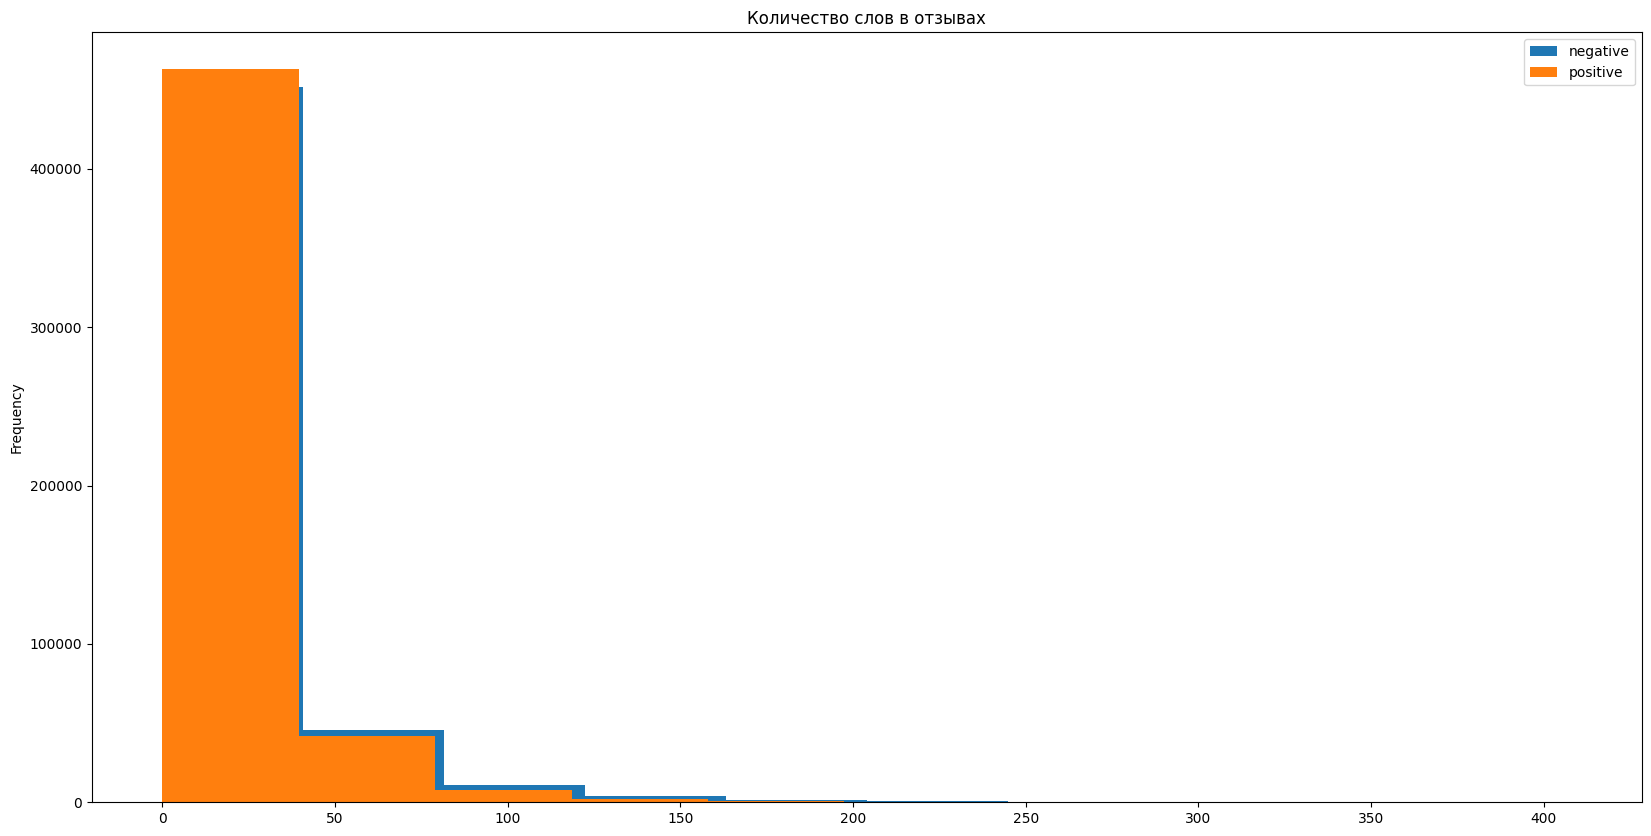

In [95]:
# посмотрим, какая длина отзывов встречается в наших данных

data.review_total_negative_word_counts.plot.hist(label = 'negative')
data.review_total_positive_word_counts.plot.hist(label = 'positive')
plt.title(label='Количество слов в отзывах')
plt.legend()

In [96]:
# мы видим, что основная масса отзывов содержит очень мало текста. Посмотрим, какие значения встречаются чаще всего
# приведем тексты отзывов к нижнему регистру
def get_lower_case(text):
    text = text.lower()
    return text

data['negative_review'] = data['negative_review'].apply(get_lower_case)
data['positive_review'] = data['positive_review'].apply(get_lower_case)

# посмотрим на 40 самых часто встречающихся вариантов в каждой категории отзывов
negative_count = data.negative_review.value_counts()
negative_count_list = negative_count[:40].index
print(negative_count_list)

positive_count = data.positive_review.value_counts()
positive_count_list = positive_count[:40].index
print(positive_count_list)

Index(['no negative', ' nothing', ' nothing ', ' n a', ' none', ' ',
       ' breakfast', ' small room', ' location', ' all good',
       ' nothing really', ' everything', ' no complaints', ' nil', ' price',
       ' nothing really ', ' na', ' nothing at all', ' small rooms',
       ' nothing to dislike', ' nothing at all ', ' none ', ' no complaints ',
       ' room size', ' no', ' expensive', ' staff', ' very small room',
       ' all good ', ' everything was perfect', ' absolutely nothing ',
       ' can t think of anything ', ' everything was perfect ',
       ' nothing to dislike ', ' non', ' leaving',
       ' nothing to complain about ', ' everything was great ', ' leaving ',
       ' having to leave '],
      dtype='object')
Index(['no positive', ' location', ' everything', ' nothing', ' the location',
       ' great location', ' good location', ' location ', ' breakfast',
       ' everything ', ' friendly staff', ' staff', ' excellent location',
       ' great location ', ' lo

In [97]:
# уберем из этих списков отзывы, которые несут смысловую нагрузку, оставив максимально бессмысленные, создадим два списка

not_negative_list = ['no negative', ' nothing', ' nothing ', ' n a', ' none', ' ',
                     ' all good', ' nothing really', ' no complaints', ' nil', ' nothing really ', ' na',
                     ' nothing at all', ' nothing to dislike', ' nothing at all ', ' none ', ' no complaints ', ' no',
                     ' absolutely nothing ', ' can t think of anything ', ' nothing to dislike ', ' non', ' nothing to complain about ']

not_positive_list = ['no positive', ' nothing', ' nothing ',  ' ']

# предположим, что если отсутствует комментарий в столбце с негативными отзывами, значит, оценка отеля нейтральная, заменим все непонятные значения на neutral
# в случае столбца positive_review сделаем то же самое

negative_mask = data.negative_review.isin(not_negative_list)
positive_mask = data.positive_review.isin(not_positive_list)

data.loc[negative_mask, 'negative_review'] = 'neutral'
data.loc[positive_mask, 'positive_review'] = 'neutral'

# посмотрим, что получилось
data.head(4)

,additional_number_of_scoring,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,reviewer_country,review_month
0,904,8.1,Hotel Da Vinci,would have appreciated a shop in the hotel th...,52,16670,hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,United Kingdom,7
1,612,8.6,Urban Lodge Hotel,no tissue paper box was present at the room,10,5018,neutral,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,Belgium,12
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,pillows,3,351,nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,Sweden,11
3,241,9.1,Hotel Principe Di Savoia,neutral,0,1543,everything including the nice upgrade the hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0,Italy,United States of America,10


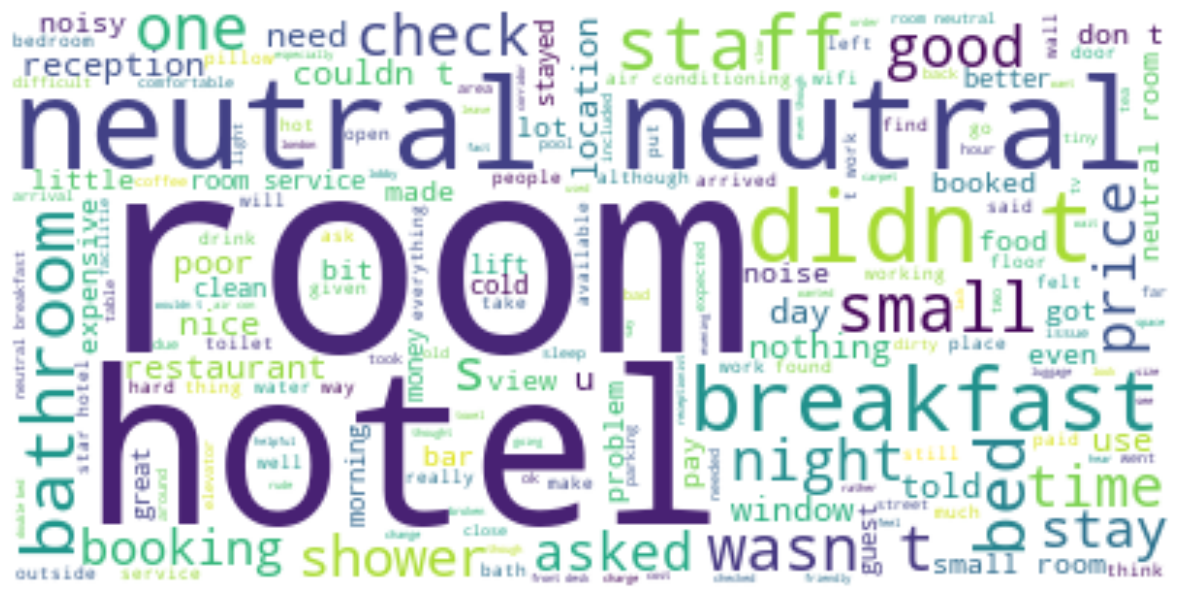

In [98]:
# посмотрим, какие слова чаще всего использовались в негативных отзывах

negative_text = " ".join(i for i in data.negative_review)
stopwords = set(STOPWORDS)
negative_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(negative_text)
plt.figure(figsize=(15,10))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

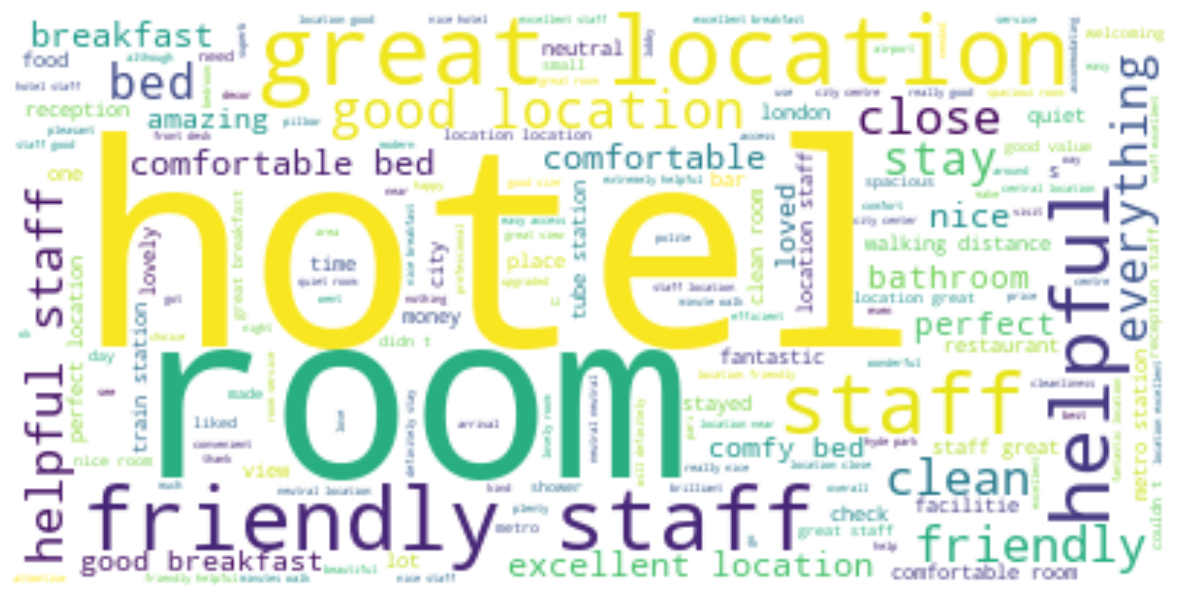

In [99]:
# рассмотрим типы слов, которые использовались в позитивных отзывах

positive_text = " ".join(i for i in data.positive_review)
positive_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive_text)
plt.figure(figsize=(15,10))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [100]:
# основываясь на оценке настроений каждого пользовательского отзыва, преобразуем признаки негативной и позитивной оценки
# каждый в три новых признака: Положительный, Отрицательный и Нейтральный

sent_analyzer = SentimentIntensityAnalyzer()

negative_polarity_scores = [sent_analyzer.polarity_scores(x) for x in data.negative_review.tolist()]
positive_polarity_scores = [sent_analyzer.polarity_scores(x) for x in data.positive_review.tolist()]

In [101]:
data['n_negative'] = [x['neg'] for x in negative_polarity_scores]
data['n_neutral'] = [x['neu'] for x in negative_polarity_scores]
data['n_positive'] = [x['pos'] for x in negative_polarity_scores]
data['n_compound'] = [x['compound'] for x in negative_polarity_scores]

data['p_negative'] = [x['neg'] for x in positive_polarity_scores]
data['p_neutral'] = [x['neu'] for x in positive_polarity_scores]
data['p_positive'] = [x['pos'] for x in positive_polarity_scores]
data['p_compound'] = [x['compound'] for x in positive_polarity_scores]

In [102]:
# посмотрим на результат
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,...,reviewer_country,review_month,n_negative,n_neutral,n_positive,n_compound,p_negative,p_neutral,p_positive,p_compound
0,904,8.1,Hotel Da Vinci,would have appreciated a shop in the hotel th...,52,16670,hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",...,United Kingdom,7,0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615
1,612,8.6,Urban Lodge Hotel,no tissue paper box was present at the room,10,5018,neutral,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",...,Belgium,12,0.216,0.784,0.000,-0.2960,0.0,1.000,0.000,0.0000
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,pillows,3,351,nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",...,Sweden,11,0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908


In [103]:
# после чего удалим признаки позитивной и негативной оценки
data.drop(['negative_review', 'positive_review'], axis=1 , inplace=True)

<h3>5. Анализ тегов.</h3>

In [104]:
# вспомним, как выглядят данные
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,...,reviewer_country,review_month,n_negative,n_neutral,n_positive,n_compound,p_negative,p_neutral,p_positive,p_compound
0,904,8.1,Hotel Da Vinci,52,16670,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,...,United Kingdom,7,0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615
1,612,8.6,Urban Lodge Hotel,10,5018,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,...,Belgium,12,0.216,0.784,0.000,-0.2960,0.0,1.000,0.000,0.0000
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,3,351,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,...,Sweden,11,0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908


In [105]:
# Разберем признак тегов. Посмотрим, сколько всего тегов у нас есть.

count_dict = {}
for tags_list in data['tags']:
    tags = ''.join(tags_list)
    tags = tags.replace("'", "")
    tags = tags.replace("[", "")
    tags = tags.replace("]", "")
    tags = tags.split(",")
    for tag in tags:
        tag = tag.strip()
        if tag in count_dict:
            count_dict[tag] += 1
        else:
            count_dict[tag] = 1
print(len(count_dict))

2428


In [106]:
# получилось 2428 тегов, это довольно много. Посмотрим на те, которые встречаются более 10000 раз.
tags_list = [k for k, v in count_dict.items() if v > 10000]
print(len(tags_list))
print(tags_list)

22
['Leisure trip', 'Couple', 'Double Room', 'Stayed 2 nights', 'Group', 'Stayed 1 night', 'Business trip', 'Solo traveler', 'Submitted from a mobile device', 'Standard Double or Twin Room', 'Stayed 3 nights', 'Double or Twin Room', 'Superior Double Room', 'Stayed 4 nights', 'Standard Double Room', 'Stayed 5 nights', 'Family with young children', 'Family with older children', 'Superior Double or Twin Room', 'Classic Double Room', '2 rooms', 'Deluxe Double Room']


In [107]:
# я не буду делать анализ тегов на данном этапе, но я предлагаю создать признак количества тегов, указанных в каждом отзыве 
# будет он полезен или нет, скоро узнаем

def get_tags_count(tags):
    tags = tags.replace("'", "")
    tags = tags.replace("[", "")
    tags = tags.replace("]", "")
    tags = tags.split(",")
    return(len(tags))

data['tags_count'] = data['tags'].apply(get_tags_count)

# удалим признак тегов

data.drop(['tags'], axis=1 , inplace=True)

<h3>6. Признаки широты и долготы.</h3>

In [108]:
# Столбцы широты и долготы содержат довольно много пропусков. Учитывая то, что мы смогли извлечь названия стран из адреса, удалим широту и долготу.

data.drop(['lat', 'lng'], axis=1 , inplace=True)

# и посмотрим на то, что у нас осталось
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,...,review_month,n_negative,n_neutral,n_positive,n_compound,p_negative,p_neutral,p_positive,p_compound,tags_count
0,904,8.1,Hotel Da Vinci,52,16670,62,1,13 days,0,0.0,...,7,0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615,4
1,612,8.6,Urban Lodge Hotel,10,5018,0,7,234 day,0,0.0,...,12,0.216,0.784,0.000,-0.2960,0.0,1.000,0.000,0.0000,4
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,3,351,5,15,616 day,0,0.0,...,11,0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908,5


<h3>7. Признаки давности отзыва и названия отеля</h3>

In [109]:
data.days_since_review.describe()

count     515738
unique       731
top       1 days
freq        2585
Name: days_since_review, dtype: object

In [110]:
# приведем признак days_since_review к числовому формату
def get_days_since_review(arg):
    arg = arg.split(' ')
    arg = arg[0]
    return arg
data.days_since_review = data.days_since_review.apply(get_days_since_review)

In [111]:
data.head()

,additional_number_of_scoring,average_score,hotel_name,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,...,review_month,n_negative,n_neutral,n_positive,n_compound,p_negative,p_neutral,p_positive,p_compound,tags_count
0,904,8.1,Hotel Da Vinci,52,16670,62,1,13,0,0.0,...,7,0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615,4
1,612,8.6,Urban Lodge Hotel,10,5018,0,7,234,0,0.0,...,12,0.216,0.784,0.000,-0.2960,0.0,1.000,0.000,0.0000,4
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,3,351,5,15,616,0,0.0,...,11,0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908,5
3,241,9.1,Hotel Principe Di Savoia,0,1543,27,9,656,0,0.0,...,10,0.000,1.000,0.000,0.0000,0.0,0.621,0.379,0.9153,4
4,834,9.1,Hotel Esther a,0,4687,7,2,444,0,0.0,...,5,0.000,1.000,0.000,0.0000,0.0,0.230,0.770,0.7717,5


In [112]:
# название отеля очень важный признак, но их огромное количество, поэтому в данной работе от него избавимся

data.drop(['hotel_name'], axis=1 , inplace=True)

<h3>8. Корреляция признаков</h3>

C:\TEMP\ipykernel_1544\3487454497.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(method = 'spearman'), annot = True, cmap='PiYG')


Text(0.5, 1.0, 'Корреляция Спирмена')

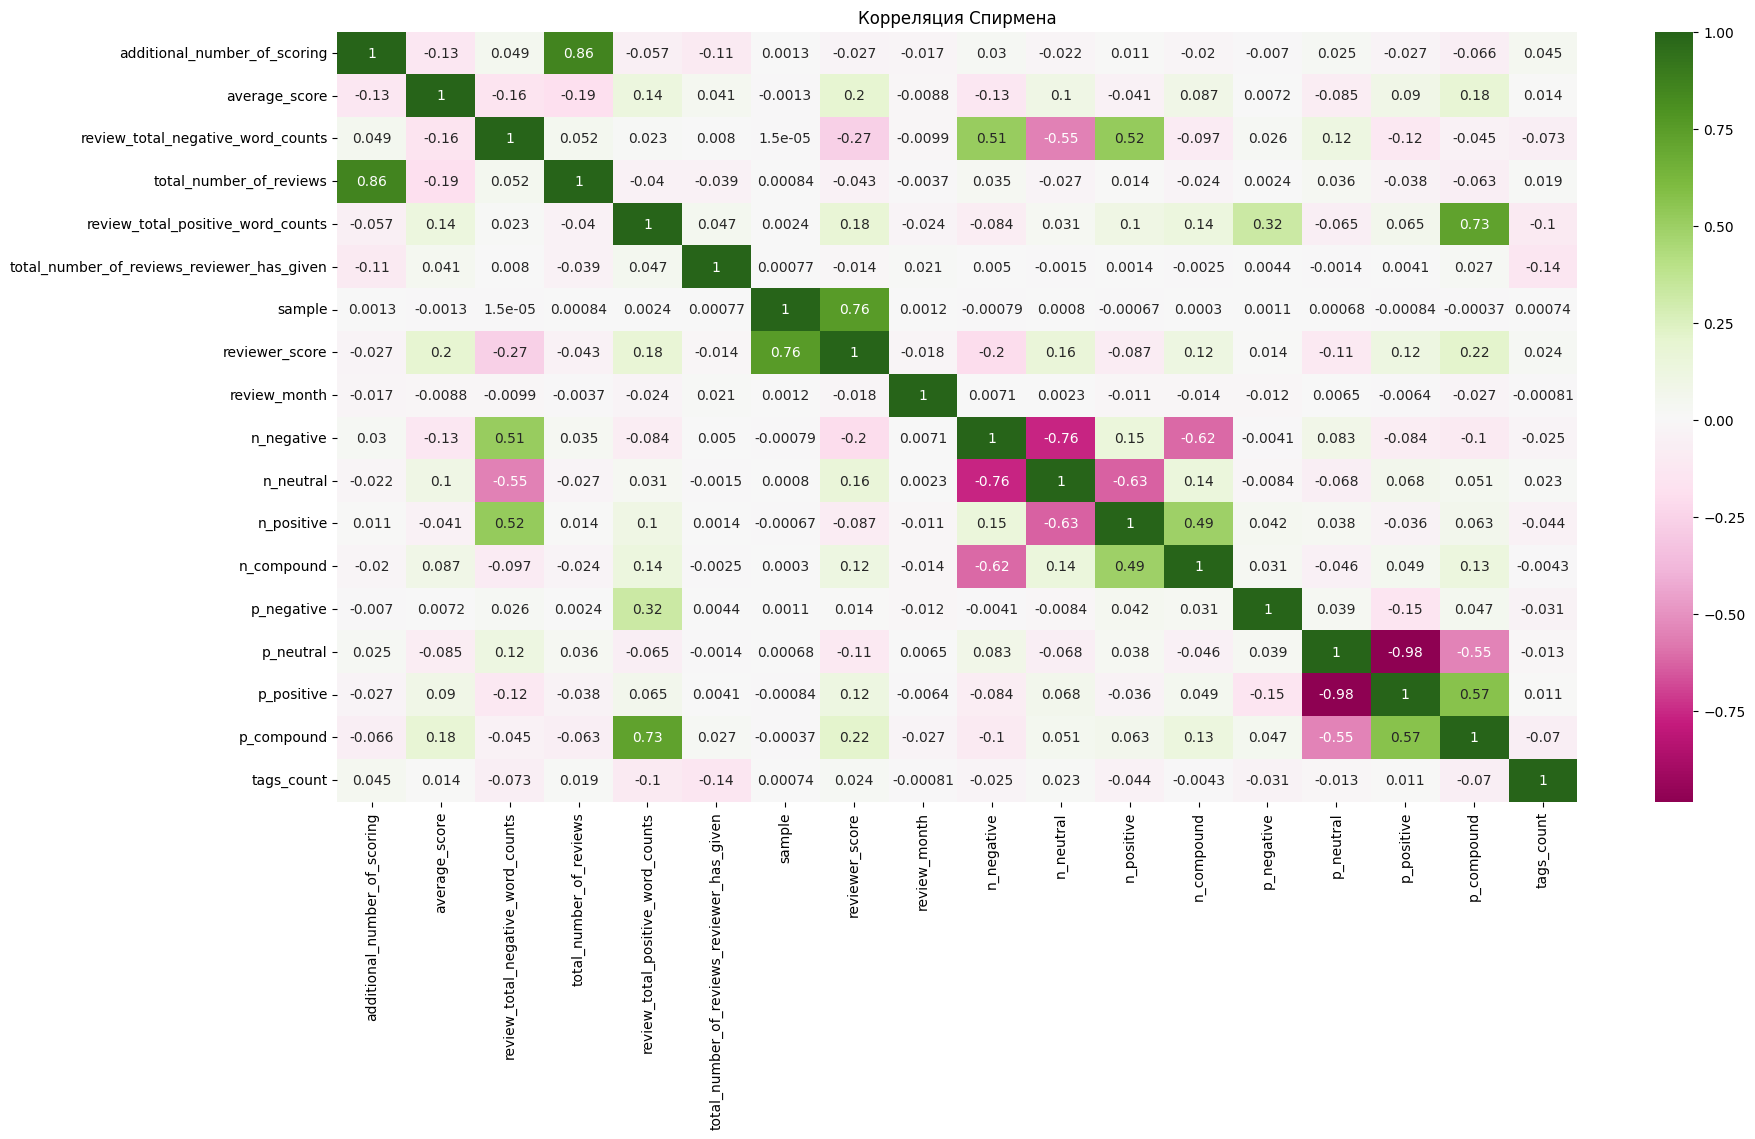

In [113]:
# построим тепловую матрицу корреляций
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(data.corr(method = 'spearman'), annot = True, cmap='PiYG')
plt.title('Корреляция Спирмена')

In [114]:
# имеется сильная прямая зависимость между признаками "additional_number_of_scoring" и "total_number_of_reviews", удалим один из этих признаков
 
drop_list = ['additional_number_of_scoring']
data.drop(drop_list, axis=1 , inplace=True)
data.head(3)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,hotel_country,reviewer_country,review_month,n_negative,n_neutral,n_positive,n_compound,p_negative,p_neutral,p_positive,p_compound,tags_count
0,8.1,52,16670,62,1,13,0,0.0,Italy,United Kingdom,7,0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615,4
1,8.6,10,5018,0,7,234,0,0.0,Netherlands,Belgium,12,0.216,0.784,0.000,-0.2960,0.0,1.000,0.000,0.0000,4
2,8.3,3,351,5,15,616,0,0.0,Spain,Sweden,11,0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908,5


C:\TEMP\ipykernel_1544\1739920559.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(method = 'spearman'), annot = True, cmap='PiYG')


Text(0.5, 1.0, 'Корреляция Спирмена')

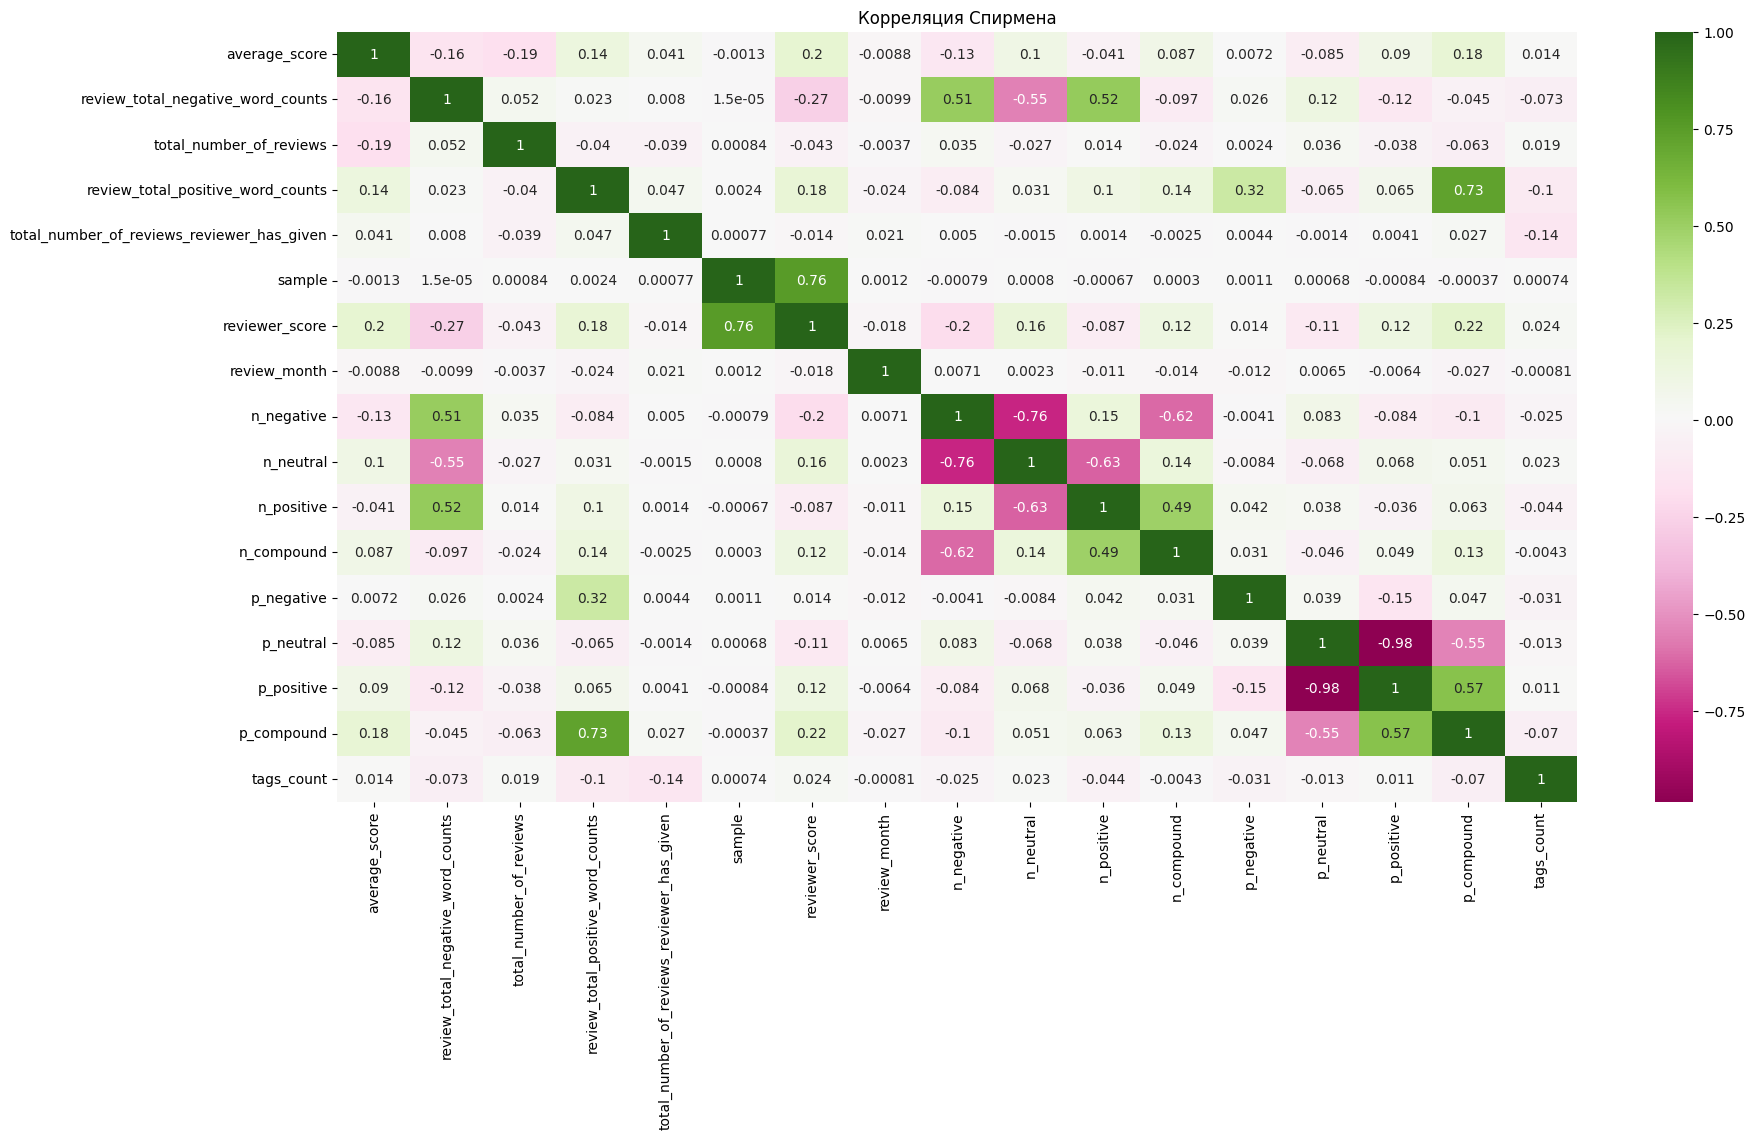

In [115]:
# снова посмотрим на тепловую матрицу корреляций
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(data.corr(method = 'spearman'), annot = True, cmap='PiYG')
plt.title('Корреляция Спирмена')

<h3>9. Кодирование признаков</h3>

In [116]:
# посмотрим на основную информацию о нечисловых признаках
data.describe(include='object')

,days_since_review,hotel_country,reviewer_country
count,515738,515738,515738
unique,731,6,31
top,1,United Kingdom,United Kingdom
freq,2585,262301,245246


In [117]:
# у нас получилось 6 значений в признаке страны отеля и 31 значение признака страны туриста
# таким образом, для кодирования hotel_country нам подходит OneHot Encoding, для признака reviewer_country - Binary Encoding

#закодируем признак hotel_country
data = pd.get_dummies(data, columns=['hotel_country'])

# посмотрим, что получилось
data.head(3)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,reviewer_country,review_month,...,p_neutral,p_positive,p_compound,tags_count,hotel_country_Austria,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom
0,8.1,52,16670,62,1,13,0,0.0,United Kingdom,7,...,0.671,0.329,0.9615,4,0,0,1,0,0,0
1,8.6,10,5018,0,7,234,0,0.0,Belgium,12,...,1.000,0.000,0.0000,4,0,0,0,1,0,0
2,8.3,3,351,5,15,616,0,0.0,Sweden,11,...,0.260,0.740,0.6908,5,0,0,0,0,1,0


In [118]:
# закодируем признак reviewer_country

bin_encoder = ce.BinaryEncoder(cols=['reviewer_country']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_country'])
data = pd.concat([data, type_bin], axis=1)

# удалим признак reviewer_country
data.drop(['reviewer_country'], axis=1 , inplace=True)

data.head(3)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,review_month,n_negative,...,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,reviewer_country_0,reviewer_country_1,reviewer_country_2,reviewer_country_3,reviewer_country_4
0,8.1,52,16670,62,1,13,0,0.0,7,0.129,...,0,1,0,0,0,0,0,0,0,1
1,8.6,10,5018,0,7,234,0,0.0,12,0.216,...,0,0,1,0,0,0,0,0,1,0
2,8.3,3,351,5,15,616,0,0.0,11,0.000,...,0,0,0,1,0,0,0,0,1,1


In [119]:
data.nunique(dropna=False)

average_score                                    34
review_total_negative_word_counts               402
total_number_of_reviews                        1142
review_total_positive_word_counts               365
total_number_of_reviews_reviewer_has_given      198
days_since_review                               731
sample                                            2
reviewer_score                                   38
review_month                                     12
n_negative                                      798
n_neutral                                       849
n_positive                                      780
n_compound                                    15776
p_negative                                      654
p_neutral                                       916
p_positive                                      925
p_compound                                     6910
tags_count                                        6
hotel_country_Austria                             2
hotel_countr

C:\TEMP\ipykernel_1544\2404832614.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)


<Axes: >

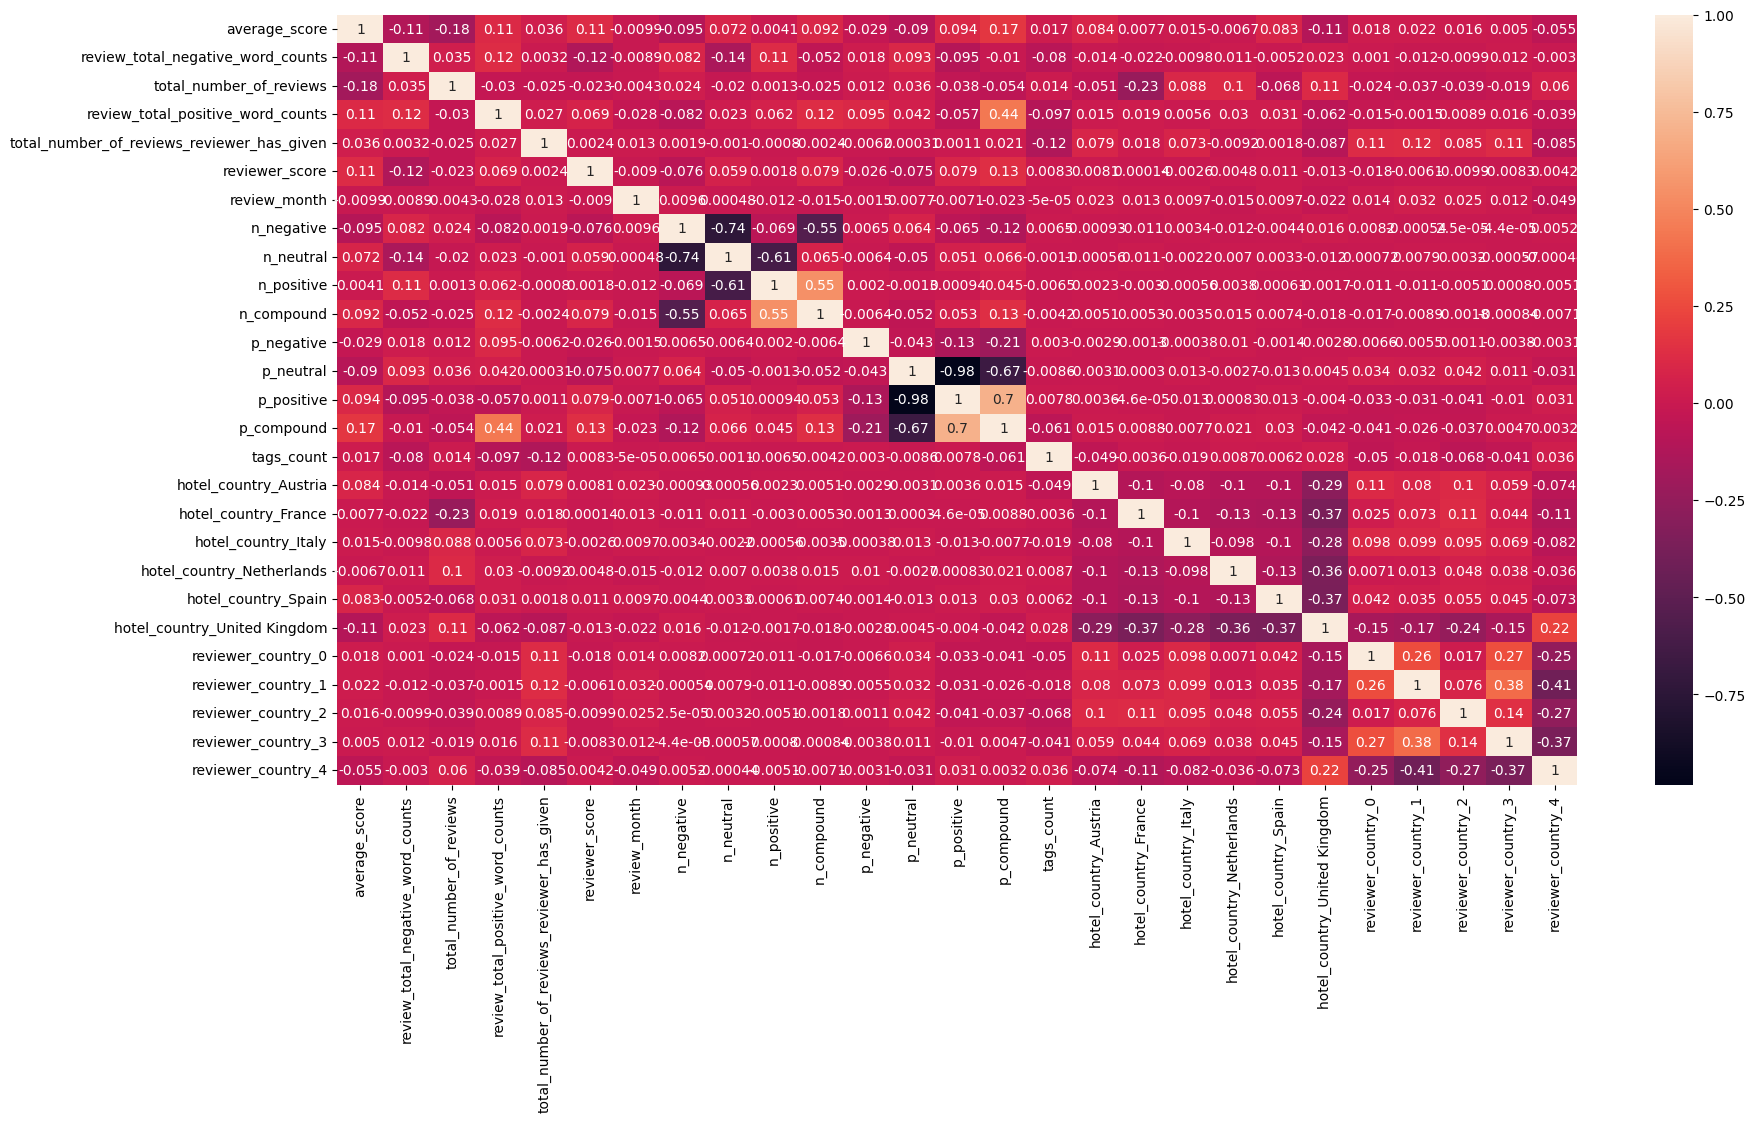

In [120]:
plt.rcParams['figure.figsize'] = (20,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [121]:
# посмотрим, остались ли у нас признаки типа 'object', так как модель на таких признаках обучаться не будет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  object 
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   review_month                                515738 non-null  int64  
 9   n_negative                                  515738 non-null  float64
 

<h3>10. Обучение модели</h3>

In [122]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [123]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386803 entries, 128935 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               386803 non-null  float64
 1   review_total_negative_word_counts           386803 non-null  int64  
 2   total_number_of_reviews                     386803 non-null  int64  
 3   review_total_positive_word_counts           386803 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 5   days_since_review                           386803 non-null  object 
 6   reviewer_score                              386803 non-null  float64
 7   review_month                                386803 non-null  int64  
 8   n_negative                                  386803 non-null  float64
 9   n_neutral                                   386803 non-null  floa

In [124]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 0 to 128934
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               128935 non-null  float64
 1   review_total_negative_word_counts           128935 non-null  int64  
 2   total_number_of_reviews                     128935 non-null  int64  
 3   review_total_positive_word_counts           128935 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  128935 non-null  int64  
 5   days_since_review                           128935 non-null  object 
 6   reviewer_score                              128935 non-null  float64
 7   review_month                                128935 non-null  int64  
 8   n_negative                                  128935 non-null  float64
 9   n_neutral                                   128935 non-null  float64
 

In [125]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [126]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 28), (386803, 28), (386803, 27), (309442, 27), (77361, 27))

In [127]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [128]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [129]:
%%time

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


CPU times: total: 10min 55s
Wall time: 59.3 s


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished


In [130]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8794760689679366


<Axes: >

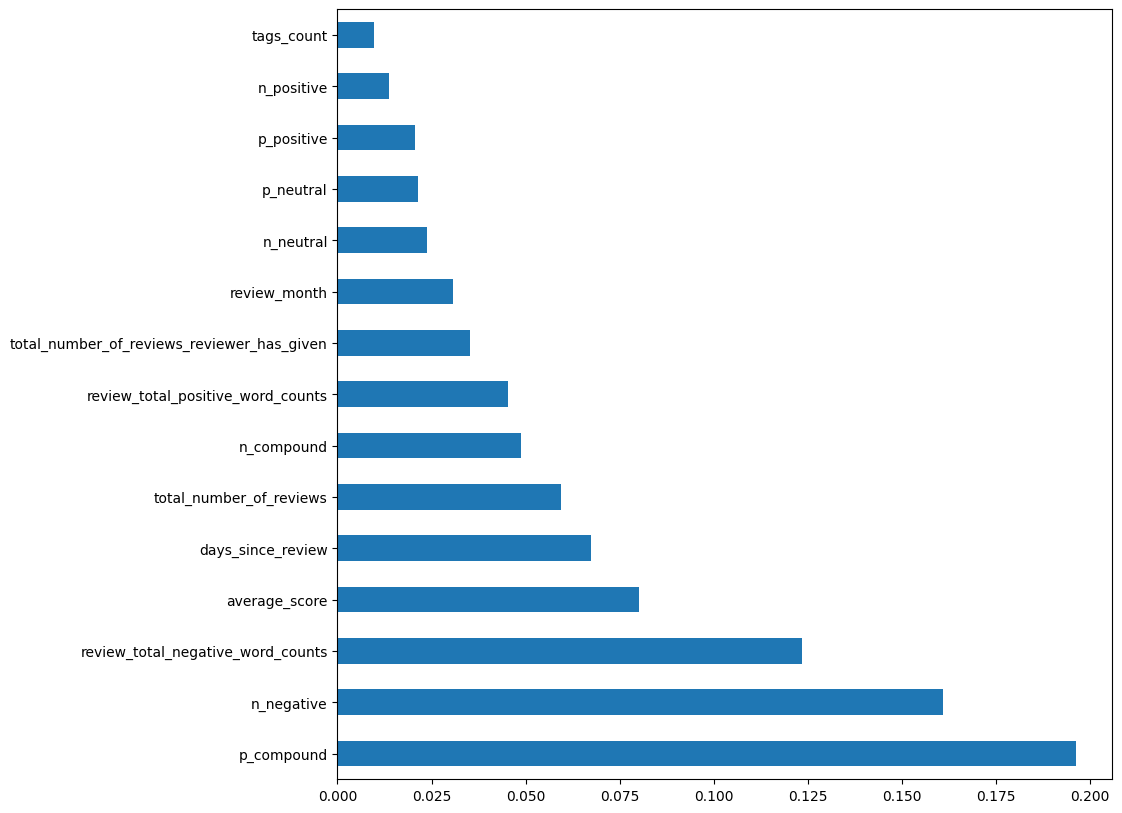

In [131]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [132]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,review_month,n_negative,n_neutral,...,hotel_country_France,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,reviewer_country_0,reviewer_country_1,reviewer_country_2,reviewer_country_3,reviewer_country_4
97997,9.1,0,869,4,56,641,0.0,11,0.000,1.000,...,0,0,0,1,0,0,0,1,0,1
39972,8.4,5,2902,7,1,537,0.0,2,0.474,0.526,...,0,0,0,0,1,0,0,0,0,1
45549,7.9,12,966,0,2,148,0.0,3,0.538,0.462,...,0,0,1,0,0,0,0,0,0,1
61058,8.9,29,1517,3,1,521,0.0,2,0.000,0.892,...,0,0,0,1,0,0,1,0,1,0
74391,9.2,2,1740,12,1,333,0.0,9,0.000,1.000,...,0,0,0,0,1,0,0,0,0,1
119572,9.2,11,136,81,2,380,0.0,7,0.000,0.737,...,0,1,0,0,0,0,1,0,1,0
35655,8.2,0,2996,22,2,366,0.0,8,0.000,1.000,...,0,0,0,0,1,0,0,0,0,1
40161,7.6,13,3383,6,5,486,0.0,4,0.000,1.000,...,0,0,1,0,0,0,0,0,1,0
123921,8.5,16,2708,14,2,557,0.0,1,0.000,1.000,...,0,0,0,1,0,0,1,1,0,0
73070,9.3,0,1108,4,7,467,0.0,4,0.000,1.000,...,0,1,0,0,0,0,1,0,1,0


In [133]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [134]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [135]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.2s finished


In [136]:
predict_submission

array([8.602, 7.668, 8.661, ..., 8.323, 9.64 , 6.499])

In [137]:
list(sample_submission)

['reviewer_score', 'id']

In [138]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.602,488440
1,7.668,274649
2,8.661,374688
3,9.718,404352
4,9.622,451596
5,8.995,302161
6,7.604,317079
7,7.341,13963
8,8.170,159785
9,7.382,195089
